In [5]:
""" Principal Component Analysis (PCA) with Illumination

Dimensionality reduction technique to be used for eigenface facial recognition
"""

import numpy as np
import scipy as sp
import scipy.io as sio
import matplotlib.pyplot as plt
from PIL import Image
import random as rand
from sklearn.naive_bayes import GaussianNB

DATAPATH = '../data/raw/'

# Cropped 40x48 (1920) images of 68 subjects under 21 different illuminations
illumination_contents = sio.loadmat(DATAPATH + 'illumination.mat')
illum = illumination_contents['illum']

illum_split = int(illum.shape[1]/2)
train_illum = illum[:, :illum_split, :]
test_illum = illum[:, illum_split:, :]

NUM_ILLUMS = train_illum.shape[1]
NUM_SUBJECTS = train_illum.shape[2]

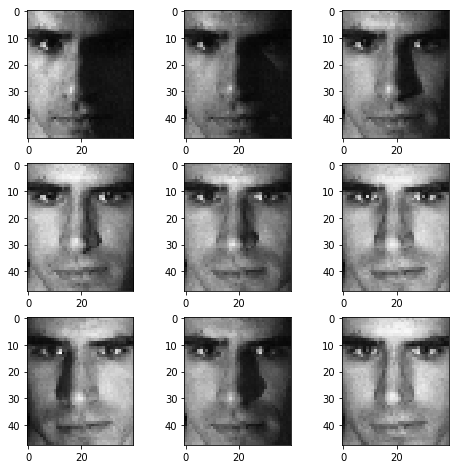

In [10]:
# Recover image from vector
def recover_img(v, dim1=40, dim2=48, rotate=270):
    return Image.fromarray(v.reshape(dim1, dim2)).rotate(270, expand=True)

# Plot random illuminations of some person
def plot_random(d):
    j = rand.randint(0,d.shape[2])
    fig=plt.figure(figsize=(8, 8))
    columns = 3
    rows = 3
    for i in range(1, d.shape[1]):
        img = recover_img(d[:,i,j])
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)

plot_random(train_illum)

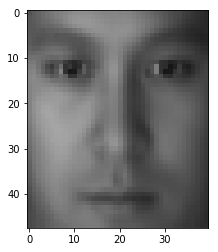

In [24]:
# Average Face
mean_img = recover_img(train_illum.mean(axis=(1,2)))
plt.imshow(mean_img)

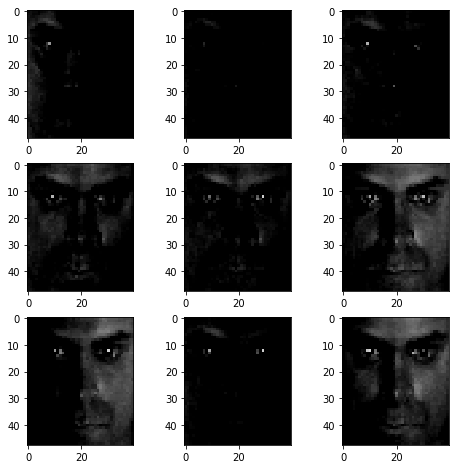

In [11]:
# Centering data (mean subtraction)
c_illum = train_illum.reshape(1920,NUM_ILLUMS*NUM_SUBJECTS).T - np.mean(train_illum, axis=(1,2))
c_illum = c_illum.T.reshape(1920,NUM_ILLUMS,NUM_SUBJECTS)
# - illum.mean(axis=(1,2))).reshape(1920,21,68)
plot_random(c_illum)

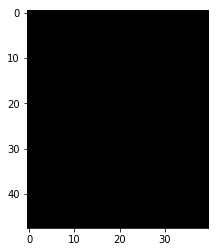

In [12]:
# Average Face
fig = plt.figure()
img = recover_img(c_illum.mean(axis=(1,2)))
plt.imshow(img)

In [13]:
cov = np.cov(c_illum.reshape(1920, NUM_ILLUMS*NUM_SUBJECTS))
cov

array([[1413.78904001, 1413.49162552, 1380.85470271, ..., -321.81505867,
        -272.91303532, -250.09276425],
       [1413.49162552, 1455.69072141, 1434.68768012, ..., -364.37389519,
        -318.50964389, -291.28117041],
       [1380.85470271, 1434.68768012, 1443.46946177, ..., -397.26436561,
        -355.18918272, -324.62718194],
       ...,
       [-321.81505867, -364.37389519, -397.26436561, ..., 3151.65785036,
        3258.93279477, 3216.08754416],
       [-272.91303532, -318.50964389, -355.18918272, ..., 3258.93279477,
        3492.33415514, 3477.64055897],
       [-250.09276425, -291.28117041, -324.62718194, ..., 3216.08754416,
        3477.64055897, 3586.44923715]])

In [14]:
eigvals, eigvecs = sp.linalg.eigh(cov)

In [15]:
# Sort by top eigenvalues
idx = eigvals.argsort()[::-1]   
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

max([max(v) for v in eigvecs[1:100]])

0.5643225824920167

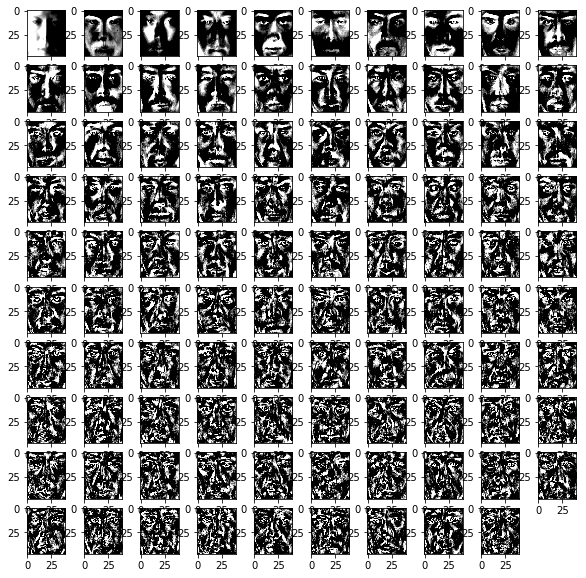

In [17]:
fig=plt.figure(figsize=(10, 10))
columns = 10
rows = 10
for i in range(1, 100):
    img = recover_img(eigvecs[:,i]*1e4)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

In [18]:
U, S, V = np.linalg.svd(c_illum.reshape(1920, NUM_ILLUMS*NUM_SUBJECTS), full_matrices=False)

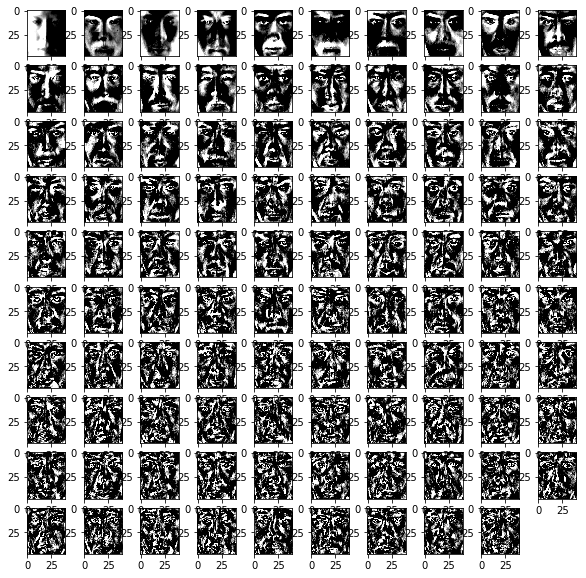

In [19]:
# Plotting eigenfaces
fig=plt.figure(figsize=(10, 10))
columns = 10
rows = 10
for i in range(1, 100):
    img = recover_img(U[:,i]*1e4)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
# fig.show()
plt.savefig('eigenfaces.png')

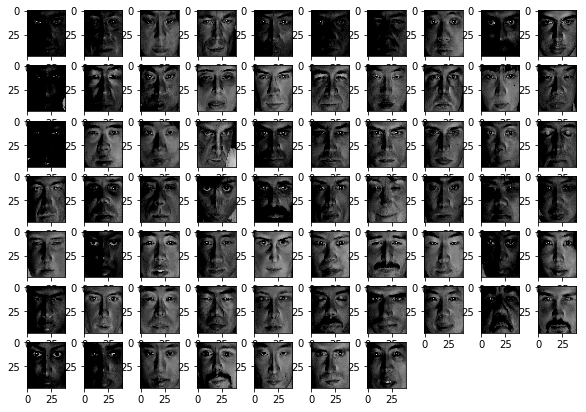

In [20]:
# Original faces (illumination 6)
fig=plt.figure(figsize=(10,10))
columns = 10
rows = 10
for i in range(1, 68):
    img = recover_img(c_illum[:,6,i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

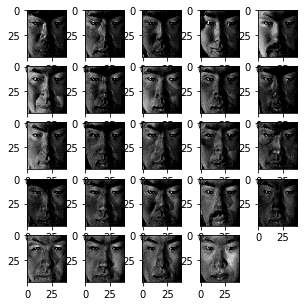

In [21]:
# Face reconstruction 
mu = c_illum.reshape(1920,NUM_ILLUMS*NUM_SUBJECTS).T
weights = np.dot(mu, U)
img_idx = 0
recon = mu + np.dot(weights[img_idx, :], U.T)
recon.shape
recon[0].shape

fig=plt.figure(figsize=(5,5))
columns = 5
rows = 5
for i in range(1, 25):
    recon = mu + np.dot(weights[(i+1)*10, :], U.T)
    img = recover_img(recon[320])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

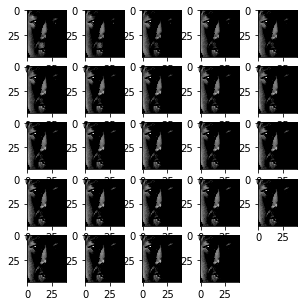

In [26]:
# Constrained reconstruction (buggy)
img_idx = 600

fig=plt.figure(figsize=(5,5))
columns = 5
rows = 5
k=0
for i in range(1, 25):
    recon = mu + np.dot(weights[img_idx, 0:k], U[:, 0:k].T)
    img = recover_img(recon[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    k+=5

In [25]:
# Create Bayes Classifier (Scikit)
model = GaussianNB()
train_illum.shape
train_x = train_illum.reshape(1920, NUM_SUBJECTS*NUM_ILLUMS).T
train_y = np.array([i for x in range(NUM_SUBJECTS) for i in [x]*NUM_ILLUMS])  # labels for subject

img = recover_img(train_x[1])
#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets 
model.fit(train_x, train_y)

#Predict Output
test_x = test_illum.reshape(1920,-1).T
test_y = np.array([i for x in range(NUM_SUBJECTS) for i in [x]*11])
# test_y = model.predict(test_x[0].reshape(1, -1))   # test one sample
predict = model.predict(test_x)
(predict == test_y)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [24]:
test_illum.shape
train_illum.shape

(1920, 10, 68)